In [5]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = pd.read_csv('./data/bbb.csv', sep=';')
df = df[df['Objects'].str.contains('_c0')]
df['Objects'] = df['Objects'].str.replace('_c0', '')
df_label = pd.read_csv('./data/bbb_label.csv', sep=' ', header=None)
# give a name to the columns 
df_label.columns = ['Objects', 'label']
# select only row with the same name as in the label file
df = df[df['Objects'].isin(df_label['Objects'])]
df = df.set_index('Objects')
df_label = df_label.set_index('Objects')
# add all in a single dataframe
df = df.join(df_label)
print(df.head())

                V        S        R        G        W1       W2       W3  \
Objects                                                                    
MOL_0001  747.125  482.581  1.54819  1.33424  1098.380  579.750  272.750   
MOL_0002  952.125  637.029  1.49463  1.58788  1294.120  597.500  262.625   
MOL_0004  549.625  368.758  1.49047  1.21149   798.000  324.500  105.500   
MOL_0009  595.750  414.276  1.43805  1.33090   898.375  406.875  210.125   
MOL_0012  448.500  316.026  1.41919  1.17786   692.250  323.000  145.625   

               W4      W5      W6  ...     L4LgS     DD1     DD2    DD3  \
Objects                            ...                                    
MOL_0001  106.375  48.875  13.875  ... -0.067867  61.750  32.500  15.75   
MOL_0002  104.625  54.875  29.750  ... -0.137969  92.875  37.500  20.25   
MOL_0004   35.875  15.500   6.625  ...  0.012077   0.000   0.000   0.00   
MOL_0009   98.000  51.625  25.125  ... -0.315401  30.500  20.125  11.50   
MOL_0012   63.000

In [6]:
X = df.drop('label', axis=1)
X = X.fillna(0)
y = df['label']
print(X.shape)
CORRCUT = 0.95
# remove highly correlated features 
corr_matrix = X.corr().abs()
#print(np.triu(np.ones(corr_matrix.shape), \
#                                  k=1).astype(np.bool))
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), \
                                  k=1).astype(bool))
#print(upper)
to_drop = [column for column in upper.columns if any(upper[column] > CORRCUT)]
#for i in to_drop:
#    print(f"Removing {i} because of high correlation")
X = X.drop(X[to_drop], axis=1)
print(X.shape)

(2103, 128)
(2103, 68)


In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, \
                    test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, \
                    test_size=0.2, random_state=42) 

# We fit the scaler ONLY on the 'X_train' data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# We transform the validation and test sets using the *same* scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

c_values = [0.001, 0.01, 0.1, 1, 10, 100]
penalty_values = ['l1', 'l2']
solver = 'liblinear' # 'liblinear' supports both l1 and l2

accuracys = []
for C in c_values:
    for penalty in penalty_values:
        print(f"Training Logistic Regression with C={C} and penalty={penalty}")
        model = LogisticRegression(C=C, 
                                   penalty=penalty, 
                                   solver=solver, 
                                   max_iter=1000)
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        acc = accuracy_score(y_val, y_val_pred)
        print(f"Validation Accuracy: {acc}")
        accuracys.append((C, penalty, acc))

Training Logistic Regression with C=0.001 and penalty=l1
Validation Accuracy: 0.23738872403560832
Training Logistic Regression with C=0.001 and penalty=l2
Validation Accuracy: 0.7774480712166172
Training Logistic Regression with C=0.01 and penalty=l1
Validation Accuracy: 0.8160237388724035
Training Logistic Regression with C=0.01 and penalty=l2
Validation Accuracy: 0.827893175074184
Training Logistic Regression with C=0.1 and penalty=l1
Validation Accuracy: 0.827893175074184
Training Logistic Regression with C=0.1 and penalty=l2
Validation Accuracy: 0.8160237388724035
Training Logistic Regression with C=1 and penalty=l1
Validation Accuracy: 0.827893175074184
Training Logistic Regression with C=1 and penalty=l2
Validation Accuracy: 0.8219584569732937
Training Logistic Regression with C=10 and penalty=l1
Validation Accuracy: 0.8397626112759644
Training Logistic Regression with C=10 and penalty=l2
Validation Accuracy: 0.8367952522255193
Training Logistic Regression with C=100 and penalty=

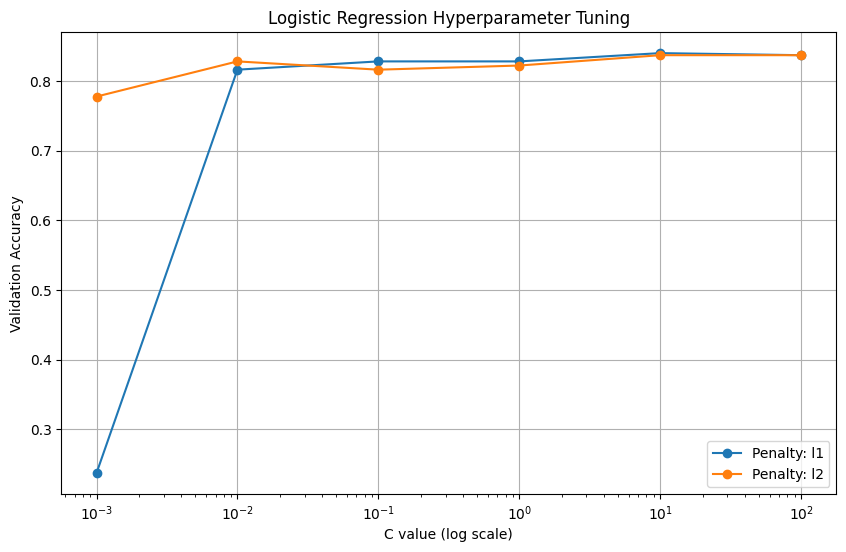

In [11]:
# plot accuracys
import matplotlib.pyplot as plt
Cs = [x[0] for x in accuracys]
penalties = [x[1] for x in accuracys]
accs = [x[2] for x in accuracys]
plt.figure(figsize=(10,6))
for penalty in penalty_values:
    accs_penalty = [accs[i] for i in range(len(accs)) if penalties[i] == penalty]
    Cs_penalty = [Cs[i] for i in range(len(Cs)) if penalties[i] == penalty]
    plt.plot(Cs_penalty, accs_penalty, marker='o', label=f'Penalty: {penalty}')
plt.xscale('log')
plt.xlabel('C value (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Logistic Regression Hyperparameter Tuning')
plt.legend()
plt.grid()
plt.show()